# Multi-Category Logistic Regression
Building a model to fit the Iris data and creating a post-predictive separation plot
to judge model fit.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import pymc3 as pm
import numpy as np
import graphviz
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets
import theano as tt

In [2]:
# load and normalize Iris data
df = datasets.load_iris()
iris_data = pd.DataFrame(df['data'], columns=df['feature_names'])
iris_data['target'] = df['target']
y_s = iris_data.target
x_n = iris_data.columns[:-1]
x_s = iris_data[x_n]
x_s = (x_s - x_s.mean()) / x_s.std()
x_s = x_s.values

In [3]:
# Multi-Category Logistic Regression Model
with pm.Model() as model_mclass:
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=3)
    beta = pm.Normal('beta', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', alpha + pm.math.dot(x_s, beta))
    θ = tt.tensor.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000)
    posterior_predictive = pm.sample_posterior_predictive(trace_s)
    
    inf_data = az.from_pymc3(
        trace=trace_s,
        posterior_predictive=posterior_predictive)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


'0.98'

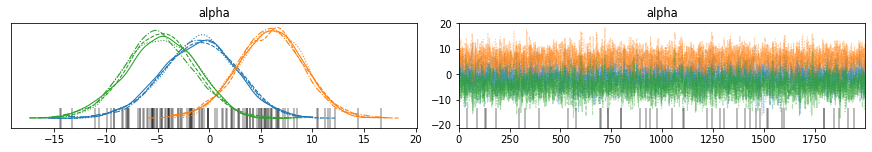

In [4]:
# Look at parameter distribution
data_pred = trace_s['μ'].mean(0)
y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0) for point in data_pred]
az.plot_trace(trace_s, var_names=['alpha'])
f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

In [5]:
# Look at the inference data
inf_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [6]:
# Looking at posterior predictive data
inf_data.posterior_predictive.yl[0,0,:]

<xarray.DataArray 'yl' (yl_dim_0: 150)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Coordinates:
    chain     int64 0
    draw      int64 0
  * yl_dim_0  (yl_dim_0) int64 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149

The posterior predictive simulation has 4 'chains' of 2000 'draws' each.  Each 'draw' is a randomly chosen set of parameter values based on the posterior probability distributions yielding a specific set of coefficients.  The above are the category predictions of the first set of coefficients for the observed data. The difference between these values and the observed data tells us how well this particular set of coefficients are at predicting the observed data.

In [7]:
diff = inf_data.posterior_predictive.yl[0,0,:] - inf_data.observed_data.yl
diff

<xarray.DataArray 'yl' (yl_dim_0: 150)>
array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Coordinates:
    chain     int64 0
    draw      int64 0
  * yl_dim_0  (yl_dim_0) int64 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149

As we can see, that this particular model mis-classifies a few of the data points.  We can use the same type of analysis by summing all the outcomes for a given chain to determine the average difficulty of fitting each data point using the general model.  Since we are summing 2000 values, a perfect model would yield 2000 * category_value or [0, 2000, 4000].  

In [8]:
# sum of outcomes of first chain
np.sum(inf_data.posterior_predictive.yl[0,:,:], axis=0)

<xarray.DataArray 'yl' (yl_dim_0: 150)>
array([   0,    4,    2,    2,    0,    3,    3,    0,    6,    4,    3,
          2,    0,    0,    8,    9,    0,    1,   18,    2,   15,    2,
          0,   17,    2,   12,    6,    3,    2,    2,    6,   21,    2,
          3,    2,    2,   10,    1,    2,    3,    3,  212,    3,   10,
          6,    9,    3,    0,    1,    1, 2018, 2030, 2107, 2026, 2097,
       2025, 2152, 1900, 2010, 1993, 1988, 2027, 2001, 2093, 1979, 2006,
       2132, 1993, 2532, 1999, 3160, 1998, 2785, 2012, 2001, 2011, 2076,
       2884, 2085, 1986, 2001, 1995, 2002, 3533, 2182, 2053, 2057, 2051,
       1993, 2011, 2020, 2044, 2003, 1959, 2008, 1987, 2002, 2007, 1924,
       2012, 4000, 3967, 3998, 3966, 4000, 3999, 3527, 3992, 3989, 4000,
       3845, 3970, 3988, 3987, 3998, 3996, 3919, 3998, 4000, 3491, 3998,
       3958, 4000, 3678, 3989, 3935, 3456, 3503, 3998, 3626, 3994, 3926,
       3999, 2752, 3591, 3999, 3999, 3916, 3410, 3973, 3998, 3960, 3964,
       3998, 4000, 3995, 3936, 3942, 3994, 3793])
Coordinates:
    chain     int64 0
  * yl_dim_0  (yl_dim_0) int64 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149

If we normalize these values to the range [0,1], then we can use these values as a 'color' to visulize this average divergence from perfect classification given by the posterior distribution of models.  

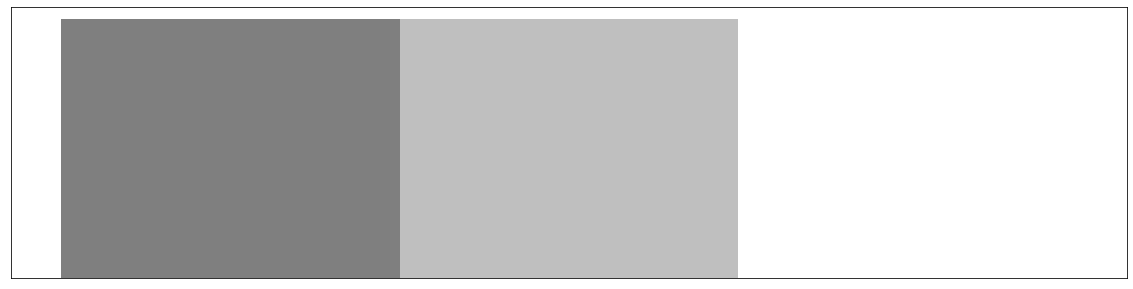

In [9]:
# Original data shows perfect separation: order [Setosa, Versicolor, Virginica]
x = np.linspace(1, 150, 150)
y = np.zeros(150)
c = np.array(inf_data.observed_data.yl/2)
tups = zip(c, c, c)
colors = list(tups)
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(x, 1, width=1, color=colors, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In a perfect model we would get three distinct bands each of the same shade ('color') as shown above.

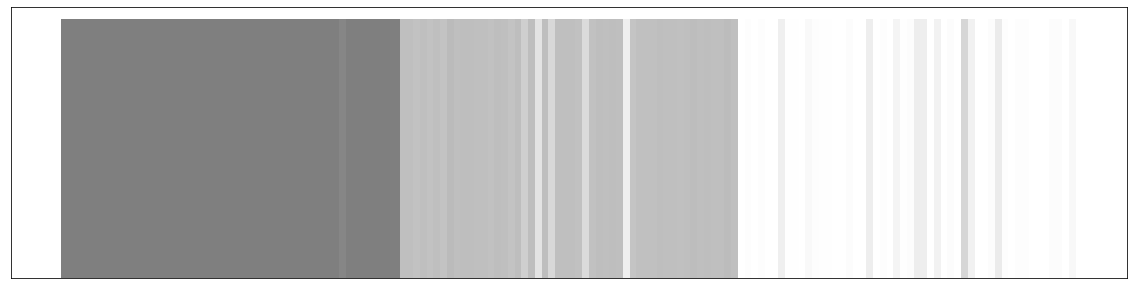

In [10]:
# Multi-Category divergence plot
# posterior predictive average values 
c = np.sum(inf_data.posterior_predictive.yl[0,:,:], axis=0)
c = c/4000
tups = zip(c, c, c)
colors = list(tups)
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(x, 1, width=1, color=colors, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Plotting our average results for the first chain, we see that our model overall has some issues classifying particular data. Setosa is sufficiently different that the model does a good job of predicting it, whereas Versicolor and Virginica have more overlap.  The degree of divergence from a perfect model can be seen in the contrast of a particular shade from the perfect shade for that category.

In a regular Logistic Regresssion where the outcome is binary, often model fit is shown using a separation plot with two shades.  Utilizing the average data, we can get a sense of the degree to which the distribution of models has issues seperating the observed data.